**Mehran Hosseinzadeh**

In [ ]:
# Imports and setups
from sklearn.model_selection import train_test_split
import re
import nltk
import string
nltk.download("book")
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from pandas import read_csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import gensim
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV



stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

In [ ]:
# some useful functions from phase1

# module for pre-prcossing text according to the desired mode from phase 1
def prepare_text(raw_text, mode):
    if mode == 1:
        return nltk.word_tokenize(raw_text)
    prepared_text = re.sub(r'\d+', '', raw_text)
    prepared_text = "".join([char.lower() for char in prepared_text if char not in string.punctuation]) 
    tokens = nltk.word_tokenize(prepared_text)
    if mode == 2:
      return tokens
    words = []
    for w in tokens:
      if w not in stop_words:
        words.append(w)
    stem_words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    return stem_words

# module to implement word2vector structure from phase 1
def w2v(X, mode):
    words = []
    sentences = []
    i = 0
    for x in X:
        i+=1
        if i % 3000 == 0:
            print("Finisehd pre-processing of {} comments".format(i))
        words.append(prepare_text(x, mode))
        sentences.append(words[-1])
    print("Fitting W2V.....")
    w2v_model = gensim.models.Word2Vec(sentences, min_count=1,size= 100,workers=3, window =3, sg = 1)
    result = []
    i = 0
    for x in X:
        if i % 3000 == 0:
            print("Finisehd w2v for {} comments".format(i))
        result.append(sum([w2v_model.wv[word] for word in words[i]]) / len(x))
        i+=1
    return np.array(result)

# module to implement bow from phase 1
def bow(X, mode, train, vectorizer):
    sentences = []
    i = 0
    for x in X:
        i+=1
        if i % 3000 == 0:
            print("Finisehd pre-processing of {} comments".format(i))
        words = prepare_text(x, mode)
        sentences.append(" ".join(words))
    print("Creating Bag of Words.....")
    if train:
        result = vectorizer.fit_transform(sentences)
    else:
        result = vectorizer.transform(sentences)
    return np.array(result.toarray())

# reading the data
df = read_csv("dataset.csv", encoding='utf-8', error_bad_lines=False, engine='python')
X = df['comment'].to_numpy()
Y = df['sentiment'].to_numpy()

In [ ]:
# loading mlp model from phase 1
import pickle

model_mlp = pickle.load(open('best.pkl', 'rb'))

In [ ]:
# module for clustering according to model_name and returning predictions
def cluster(X, model_name, k):
    if model_name == 'kmeans':
        model = KMeans(n_clusters=k, random_state=0).fit(X)
    elif model_name == 'GM':
        model = GaussianMixture(n_components=k, random_state=0).fit(X)
    elif model_name == 'minibatchkmeans':
        model = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=6).fit(X)
    predicted_clusters = model.predict(X)
    return predicted_clusters

# visualizing results by SVD in 2-D (Also by uncommenting SVD can be used)
def visualize(X, predicted_clusters, k):
    clusters_reduced = [[] for _ in range (k)]
    pca = PCA(n_components=2)
    reduced_X = pca.fit_transform(X)
    # svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    # reduced_X = svd.fit_transform(X)
    for i in range(X.shape[0]):
        clusters_reduced[predicted_clusters[i]].append(reduced_X[i])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title("PCA Representation for {0} with {1} clusters".format(model_name.upper(), k))

    for i in range(k):
        plt.scatter([x[0] for x in clusters_reduced[i]], [x[1] for x in clusters_reduced[i]], cmap='rainbow', alpha=0.7, edgecolors='w')
    plt.show()

In [ ]:
# purity score
# not implemented by sklearn! this one is adopted from stackoverflow
from sklearn import metrics

def purity_score(true_labels, predicted_clusters):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(true_labels, predicted_clusters)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [ ]:
# clustering metrics
def evaluate(predicted_clusters, true_labels, model_name):
    print("Purity score of {0} with 2 clusters: ".format(model_name), purity_score(true_labels, predicted_clusters))
    print("Homogeneity score of {0} with 2 clusters: ".format(model_name), metrics.homogeneity_score(true_labels, predicted_clusters))
    print("Completeness score of {0} with 2 clusters: ".format(model_name), metrics.completeness_score(true_labels, predicted_clusters))
    print("V-Measure score of {0} with 2 clusters: ".format(model_name), metrics.v_measure_score(true_labels, predicted_clusters))
    print("Adjusted rand score score of {0} with 2 clusters: ".format(model_name), metrics.adjusted_rand_score(true_labels, predicted_clusters))
    print("Adjusted mutual info_score score of {0} with 2 clusters: ".format(model_name), metrics.adjusted_mutual_info_score(true_labels, predicted_clusters))

In [ ]:
# analysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def analysis(labels, predictions):
    print("Classification Report:\n", classification_report(labels, predictions, target_names=['positive', 'negative']))
    print("Confusion Matrix:\n", confusion_matrix(labels, predictions))
    print("Accuracy:\n", accuracy_score(labels, predictions))

In [ ]:
vectorizer = CountVectorizer(min_df=0.01, max_df=0.5)
X_bow = bow(X, 3, train=True, vectorizer=vectorizer)

Finisehd pre-processing of 3000 comments
Finisehd pre-processing of 6000 comments
Finisehd pre-processing of 9000 comments
Finisehd pre-processing of 12000 comments
Finisehd pre-processing of 15000 comments
Finisehd pre-processing of 18000 comments
Finisehd pre-processing of 21000 comments
Finisehd pre-processing of 24000 comments
Finisehd pre-processing of 27000 comments
Finisehd pre-processing of 30000 comments
Finisehd pre-processing of 33000 comments
Finisehd pre-processing of 36000 comments
Finisehd pre-processing of 39000 comments
Finisehd pre-processing of 42000 comments
Finisehd pre-processing of 45000 comments
Creating Bag of Words.....


In [ ]:
# fitting and transferring X in order to be able to be fed to the imported MLP for extracting features
# in this part the BoW of phase 1 is retrieved
X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(X, Y, test_size=0.2, random_state=42)
vectorizer2 = CountVectorizer(min_df=0.01, max_df=0.5)
X_train_bow = bow(X_train_bow, 3, train=True, vectorizer=vectorizer2)
X_test_bow = bow(X_test_bow, 3, train=False, vectorizer=vectorizer2)

Finisehd pre-processing of 3000 comments
Finisehd pre-processing of 6000 comments
Finisehd pre-processing of 9000 comments
Finisehd pre-processing of 12000 comments
Finisehd pre-processing of 15000 comments
Finisehd pre-processing of 18000 comments
Finisehd pre-processing of 21000 comments
Finisehd pre-processing of 24000 comments
Finisehd pre-processing of 27000 comments
Finisehd pre-processing of 30000 comments
Finisehd pre-processing of 33000 comments
Finisehd pre-processing of 36000 comments
Creating Bag of Words.....
Finisehd pre-processing of 3000 comments
Finisehd pre-processing of 6000 comments
Finisehd pre-processing of 9000 comments
Creating Bag of Words.....


In [ ]:
# transforming second dataset to the learned BoW, in order to be fed to MLP for feature extraction
X_bow_v2 = bow(X, 3, train=False, vectorizer=vectorizer2)

Finisehd pre-processing of 3000 comments
Finisehd pre-processing of 6000 comments
Finisehd pre-processing of 9000 comments
Finisehd pre-processing of 12000 comments
Finisehd pre-processing of 15000 comments
Finisehd pre-processing of 18000 comments
Finisehd pre-processing of 21000 comments
Finisehd pre-processing of 24000 comments
Finisehd pre-processing of 27000 comments
Finisehd pre-processing of 30000 comments
Finisehd pre-processing of 33000 comments
Finisehd pre-processing of 36000 comments
Finisehd pre-processing of 39000 comments
Finisehd pre-processing of 42000 comments
Finisehd pre-processing of 45000 comments
Creating Bag of Words.....


In [ ]:
# Matrix Computations to get MLP features
mlp_weights = model_mlp.coefs_[0]
mlp_biases = model_mlp.intercepts_[0]
n = mlp_weights.shape[1]
X_mlp = np.zeros((X_bow_v2.shape[0], n))
for i in range(X_bow_v2.shape[0]) :
  X_out = np.maximum(0, X_bow_v2[i, :] @ mlp_weights + mlp_biases)
  X_mlp[i, :] = X_out[:]

**1.A**

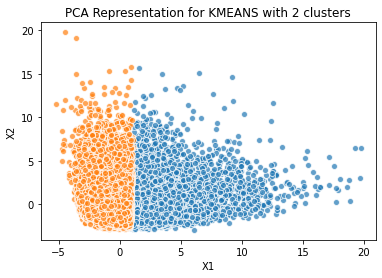

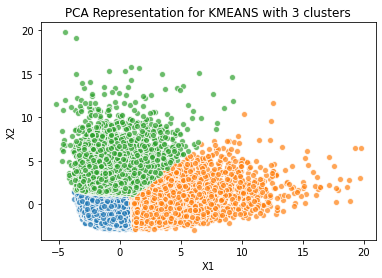

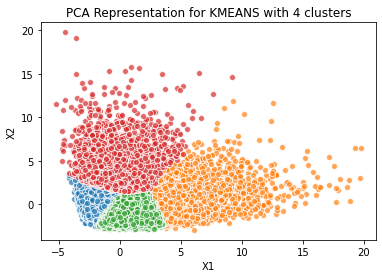

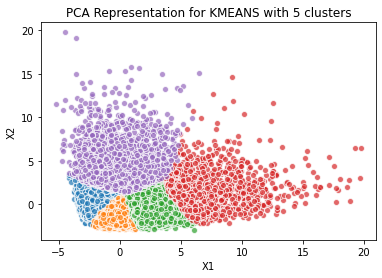

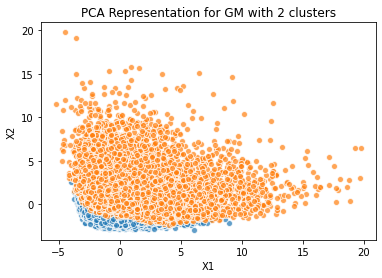

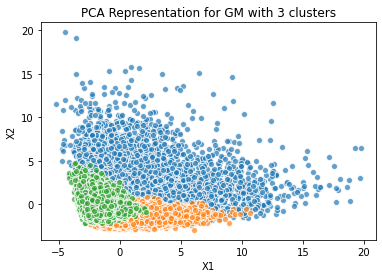

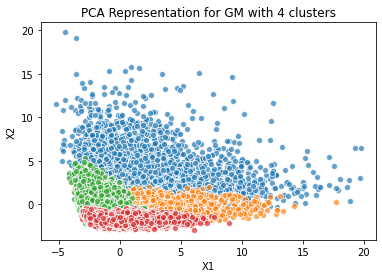

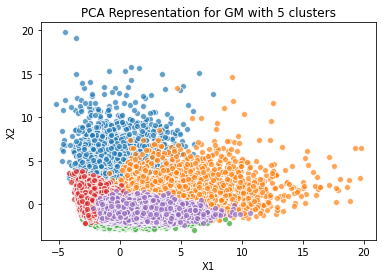

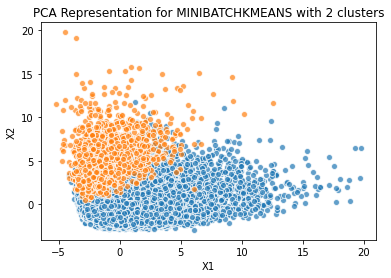

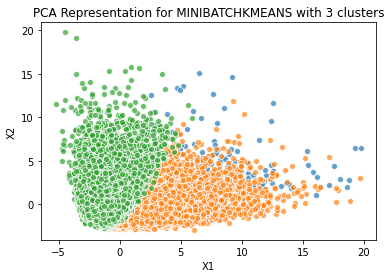

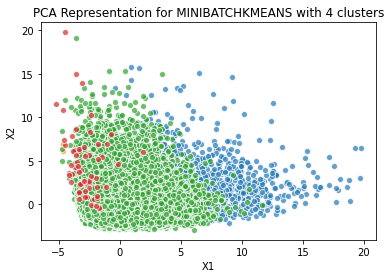

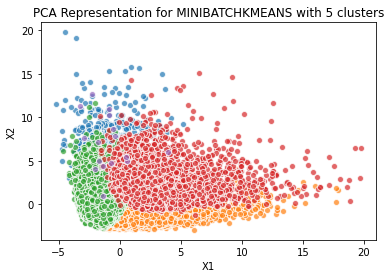

In [ ]:
# 1.A
for model_name in ['kmeans', 'GM', 'minibatchkmeans']:
    for k in [2, 3, 4, 5]:
        predicted_clusters = cluster(X_mlp, model_name, k)
        visualize(X_mlp, predicted_clusters, k)

**1.B**

In [ ]:
# 1.B
evaluate(cluster(X_mlp, 'kmeans', 2), Y, 'KMeans')
print("############################")
evaluate(cluster(X_mlp, 'GM', 2), Y, 'GM')
print("############################")
evaluate(cluster(X_mlp, 'minibatchkmeans', 2), Y, 'Mini Batch KMeans')
print("############################")

Purity score of KMeans with 2 clusters:  0.7294888888888889
Homogeneity score of KMeans with 2 clusters:  0.21825915243079658
Completeness score of KMeans with 2 clusters:  0.2589298794903722
V-Measure score of KMeans with 2 clusters:  0.23686133693832664
Adjusted rand score score of KMeans with 2 clusters:  0.2106467374699315
Adjusted mutual info_score score of KMeans with 2 clusters:  0.2368480604152697
############################
Purity score of GM with 2 clusters:  0.56
Homogeneity score of GM with 2 clusters:  0.01165749430619633
Completeness score of GM with 2 clusters:  0.012633549229061757
V-Measure score of GM with 2 clusters:  0.012125912004650621
Adjusted rand score score of GM with 2 clusters:  0.014380400373053454
Adjusted mutual info_score score of GM with 2 clusters:  0.012109439227921548
############################
Purity score of Mini Batch KMeans with 2 clusters:  0.5299333333333334
Homogeneity score of Mini Batch KMeans with 2 clusters:  0.0290574831560627
Complete

**1.C**

In [ ]:
# 1.C
# explanation in report
preds = cluster(X_mlp, 'kmeans', 3)
clusters = [[] for _ in range (3)]
for i in range(X_mlp.shape[0]):
    clusters[preds[i]].append((X_mlp[i], i))
for i in range(3):
    print("6 samples from cluster {}".format(i))
    indices = np.random.choice(len(clusters[i]), 6)
    
    print(Y[indices[0]], "->", X[indices[0]])
    print(Y[indices[1]], "->", X[indices[1]])
    print(Y[indices[2]], "->", X[indices[2]])
    print(Y[indices[3]], "->", X[indices[3]])
    print(Y[indices[4]], "->", X[indices[4]])
    print(Y[indices[5]], "->", X[indices[5]])
    print("########################################")


6 samples from cluster 0
negative -> Unforgiven is Clint Eastwoods last tribute to the once great west. But whilst i thought this was going to be good and raise the bar for future westerns to come i was sadly mistaken. Unforgiven, though simple in plot it falls flat on characters and emotions and i would certainly say that Unforgiven is Eastwoods worst film to date. Eastwoods himself seems too old to play the part of acting and directing which also adds a downfall to the overall look of the film.<br /><br />All the characters seem rushed and ragged around the edges especially Eastwoods character. The acting doesn't seem to flow and contribute to what the characters are feeling. The direction is poorly misled by quirky shots. So overall Unforgiven is not Eastwoods best and by far one of the worst westerns around.
negative -> I have seen this film 3 times. Mostly because I kept thinking while watching it, "have I missed something here?". Is there some reason this film was made? Was it tr

In [ ]:
# getting the second small dataset  
df2 = read_csv("dataset2.csv", encoding='utf-8', error_bad_lines=False, engine='python')
X2 = df2['comment'].to_numpy()
Y2 = df2['sentiment'].to_numpy()

In [ ]:
# bag of words for the small dataset to be used
X2_train_bow_v1, X2_test_bow_v1, Y2_train_bow_v1, Y2_test_bow_v1 = train_test_split(X2, Y2, test_size=0.1, random_state=42)
vectorizer1 = CountVectorizer(min_df=0.01, max_df=0.5)
X2_train_bow_v1 = bow(X2_train_bow_v1, 3, train=True, vectorizer=vectorizer1)
X2_test_bow_v1 = bow(X2_test_bow_v1, 3, train=False, vectorizer=vectorizer1)

Creating Bag of Words.....
Creating Bag of Words.....


In [ ]:
# editing labels in order to match with phase 1
df2.loc[df2.sentiment == 0, 'sentiment'] = 'negative'
df2.loc[df2.sentiment == 1, 'sentiment'] = 'positive'
Y2_revised = df2['sentiment'].to_numpy()
X2_train_bow_v2, X2_test_bow_v2, Y2_train_bow_v2, Y2_test_bow_v2 = train_test_split(X2, Y2_revised, test_size=0.1, random_state=42)
X2_train_bow_v2 = bow(X2_train_bow_v2, 3, train=False, vectorizer=vectorizer2)
X2_test_bow_v2 = bow(X2_test_bow_v2, 3, train=False, vectorizer=vectorizer2)

Creating Bag of Words.....
Creating Bag of Words.....


In [ ]:
X2_train_w2v, X2_test_w2v, Y2_train_w2v, Yw_test_w2v = train_test_split(X2_w2v, Y2, test_size=0.1, random_state=42)

In [ ]:
# GridSearch similar to phase 1 for finding best hyperparameters
def hyperparameter_cv(X, Y, model_params):
    model = MLPClassifier(warm_start=True, max_iter=300)
    clf = GridSearchCV(model, model_params, verbose=3)
    clf.fit(X, Y)
    return clf

**2.A_part_A**

In [ ]:
# 2.A_part_A
cv_params = {'hidden_layer_sizes': [(100,), (150,), (200,)], 'activation': ['logistic', 'tanh', 'relu']}
clf = hyperparameter_cv(X2_train_bow_v1, Y2_train_bow_v1, cv_params)
best_mlp2_bow_v1 = clf.best_estimator_
best_mlp2_bow_v1_params = clf.best_params_
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] activation=logistic, hidden_layer_sizes=(100,) ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation=logistic, hidden_layer_sizes=(100,), score=0.811, total=   3.6s
[CV] activation=logistic, hidden_layer_sizes=(100,) ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  activation=logistic, hidden_layer_sizes=(100,), score=0.822, total=   3.7s
[CV] activation=logistic, hidden_layer_sizes=(100,) ..................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV]  activation=logistic, hidden_layer_sizes=(100,), score=0.789, total=   3.6s
[CV] activation=logistic, hidden_layer_sizes=(100,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(100,), score=0.822, total=   4.3s
[CV] activation=logistic, hidden_layer_sizes=(100,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(100,), score=0.711, total=   3.7s
[CV] activation=logistic, hidden_layer_sizes=(150,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(150,), score=0.811, total=   4.2s
[CV] activation=logistic, hidden_layer_sizes=(150,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(150,), score=0.811, total=   4.2s
[CV] activation=logistic, hidden_layer_sizes=(150,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(150,), score=0.789, total=   4.3s
[CV] activation=logistic, hidden_layer_sizes=(150,) ..................
[CV]  activation=logistic, hidden_layer_sizes=(150,), score=0.822, total=   5.0s
[CV] ac

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.2min finished


{'activation': 'relu', 'hidden_layer_sizes': (150,)}


**2.A_part_B**

In [ ]:
# 2.A_part_B
import pickle
print("MLP results for bag of words on dataset2")
analysis(list(Y2_test_bow_v1), list(best_mlp2_bow_v1.predict(X2_test_bow_v1)))
print("######################")
pickle.dump(best_mlp2_bow_v1, open('best_mlp2_bow_v1.pkl', 'wb'))

MLP results for bag of words on dataset2
Classification Report:
               precision    recall  f1-score   support

    positive       0.92      0.86      0.89        28
    negative       0.83      0.91      0.87        22

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

Confusion Matrix:
 [[24  4]
 [ 2 20]]
Accuracy:
 0.88
######################


**2.B_part_A**

In [ ]:
# 2.B_part_A
import pickle

model_lr = pickle.load(open('LR.pkl', 'rb'))
model_lr.fit(X2_train_bow_v2, Y2_train_bow_v2)

model_mlp = pickle.load(open('best.pkl', 'rb'))
for i in range(5):
    model_mlp.partial_fit(X2_train_bow_v2, Y2_train_bow_v2)

**2.B_part_B**

In [ ]:
# 2.B_part_B
print("LR results for bag of words after fine-tuning on dataset2")
analysis(list(Y2_test_bow_v2), list(model_lr.predict(X2_test_bow_v2)))
print("######################")
print("MLP results for bag of words after fine-tuning on dataset2")
analysis(list(Y2_test_bow_v2), list(model_mlp.predict(X2_test_bow_v2)))
print("######################")
pickle.dump(model_mlp, open('best_mlp2_bow_v2.pkl', 'wb'))
pickle.dump(model_lr, open('best_lr2_bow_v2.pkl', 'wb'))

LR results for bag of words after fine-tuning on dataset2
Classification Report:
               precision    recall  f1-score   support

    positive       0.83      0.89      0.86        28
    negative       0.85      0.77      0.81        22

    accuracy                           0.84        50
   macro avg       0.84      0.83      0.84        50
weighted avg       0.84      0.84      0.84        50

Confusion Matrix:
 [[25  3]
 [ 5 17]]
Accuracy:
 0.84
######################
MLP results for bag of words after fine-tuning on dataset2
Classification Report:
               precision    recall  f1-score   support

    positive       0.93      0.89      0.91        28
    negative       0.87      0.91      0.89        22

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

Confusion Matrix:
 [[25  3]
 [ 2 20]]
Accuracy:
 0.9
######################
